# Insurance Claim Features and Model Clarify

In this notbook:
- load data from feature store
- building training set from FS
- build Pure Premium Modeling using AWS xgboost algo
- Run SageMaker Clarify processing job

What we can predict in this dataset?
1. __Claim Amount:__ total claims amount per policy holder.
1. __Claim Frequency:__ Number of claims per policy holder per exposure unit `Claim Frequency = Claim Count / Exposure`.
1. __Claim Severity:__ the average claim amount per claim for each policy holder per exposure unit `Claim Severity = Claim Cost / Claim Frequency`.
1. __Avg Claim amount:__ `Avg Claim amount = Claim Amount / Claim Count`
1. __Loss Cost:__ `Loss Cost = Claim Frequency x Claim Severity`
1. __Pure Premium:__ the mean of the total claim amount per exposure unit (the average loss per exposure) `PurePremium  = Claim Amount / Exposure`.

In [4]:
# !conda update scikit-learn -y
!pip install -U scikit-learn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 22.3 MB 26 kB/s  eta 0:00:01
  Using cached threadpoolctl-2.1.0-py3-none-any.whl (12 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1


In [7]:
import sklearn
sklearn.__version__ 

'0.22.1'

In [11]:
print(__doc__)

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc

Automatically created module for IPython interactive environment


In [12]:
import boto3
import sagemaker
from sagemaker.session import Session


region = boto3.Session().region_name

boto_session = boto3.Session(region_name=region)

sagemaker_client = boto_session.client(service_name='sagemaker', region_name=region)
featurestore_runtime = boto_session.client(service_name='sagemaker-featurestore-runtime', region_name=region)

feature_store_session = Session(
    boto_session=boto_session,
    sagemaker_client=sagemaker_client,
    sagemaker_featurestore_runtime_client=featurestore_runtime
)

#### S3 Bucket Setup For The OfflineStore

SageMaker FeatureStore writes the data in the OfflineStore of a FeatureGroup to a S3 bucket owned by you. To be able to write to your S3 bucket, SageMaker FeatureStore assumes an IAM role which has access to it. The role is also owned by you.
Note that the same bucket can be re-used across FeatureGroups. Data in the bucket is partitioned by FeatureGroup.

Set the default s3 bucket name and it will be referenced throughout the notebook.

In [13]:
feature_store_session.default_bucket()

'sagemaker-ca-central-1-314997521033'

In [14]:
# You can modify the following to use a bucket of your choosing
default_s3_bucket_name = feature_store_session.default_bucket()
prefix = 'sagemaker-featurestore-insurance'

print(default_s3_bucket_name)

sagemaker-ca-central-1-314997521033


In [15]:
from sagemaker import get_execution_role

# You can modify the following to use a role of your choosing. See the documentation for how to create this.
role = get_execution_role()
print (role)

Couldn't call 'get_role' to get Role ARN from role name AmazonSageMaker-ExecutionRole-20201209T151511 to get Role path.
Assuming role was created in SageMaker AWS console, as the name contains `AmazonSageMaker-ExecutionRole`. Defaulting to Role ARN with service-role in path. If this Role ARN is incorrect, please add IAM read permissions to your role or supply the Role Arn directly.


arn:aws:iam::314997521033:role/service-role/AmazonSageMaker-ExecutionRole-20201209T151511


In [16]:
!aws s3 ls s3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/079329190341/sagemaker/us-east-1/offline-store/insurance-policy-feature-group-06-20-23-32/

Now let's wait for the data to appear in our offline store before moving forward to creating a dataset. This will take approximately 5 minutes.

In [17]:
list_of_FG =sagemaker_client.list_feature_groups()
insurance_policy_feature_group_name = list_of_FG['FeatureGroupSummaries'][-1]['FeatureGroupName']
insurance_policy_feature_group_name

'insurance-policy-feature-group-12-02-28-15'

In [18]:
from sagemaker.feature_store.feature_group import FeatureGroup

insurance_policy_feature_group = FeatureGroup(name=insurance_policy_feature_group_name, sagemaker_session=feature_store_session)

In [19]:
account_id = boto3.client('sts').get_caller_identity()["Account"]
print(account_id)

insurance_policy_feature_group_s3_prefix = prefix + '/' + account_id + '/sagemaker/' + region + '/offline-store/' + insurance_policy_feature_group_name + '/data'
print(insurance_policy_feature_group_s3_prefix)

314997521033
sagemaker-featurestore-insurance/314997521033/sagemaker/ca-central-1/offline-store/insurance-policy-feature-group-12-02-28-15/data


## Build Training Dataset

SageMaker FeatureStore automatically builds the Glue Data Catalog for FeatureGroups (you can optionally turn it on/off while creating the FeatureGroup). In this example, we want to create one training dataset with FeatureValues from both identity and transaction FeatureGroups. This is done by utilizing the auto-built Catalog. We run an Athena query that joins the data stored in the offline store in S3 from the 2 FeatureGroups. 

In [20]:
insurance_policy_query = insurance_policy_feature_group.athena_query()

insurance_policy_table = insurance_policy_query.table_name

query_string = 'SELECT * FROM "'+insurance_policy_table+'"' #+insurance_policy_table
print('Running ' + query_string)

# run Athena query. The output is loaded to a Pandas dataframe.
#dataset = pd.DataFrame()
insurance_policy_query.run(query_string=query_string, output_location='s3://'+default_s3_bucket_name+'/'+prefix+'/query_results/')
insurance_policy_query.wait()
dataset = insurance_policy_query.as_dataframe()

dataset

Running SELECT * FROM "insurance-policy-feature-group-12-02-28-15-1618194501"


,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.00,50.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.45,80.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.08,78.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.58,85.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.22,90.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.31,90.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:31:03.467,2021-04-12 02:31:02.000,False
59996,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.20,58.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:31:03.467,2021-04-12 02:31:02.000,False
59997,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.07,72.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:31:03.467,2021-04-12 02:31:02.000,False
59998,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.88,85.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:31:03.467,2021-04-12 02:31:02.000,False


In [21]:
# Prepare query results for training.
query_execution = insurance_policy_query.get_query_execution()
query_result = 's3://'+default_s3_bucket_name+'/'+prefix+'/query_results/'+query_execution['QueryExecution']['QueryExecutionId']+'.csv'
print(query_result)

s3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/query_results/a8e91e0b-000e-4130-83a6-026530dd44d7.csv


In [22]:
#!aws s3 ls s3://sagemaker-us-east-1-079329190341/sagemaker-featurestore-insurance/query_results/

In [23]:
df_features = pd.read_csv(query_result)

In [24]:
df_features.head()

,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,vehbrand_b12,...,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount,eventtime,write_time,api_invocation_time,is_deleted
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.00,50.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.45,80.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.08,78.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.58,85.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.22,90.0,0.0,0.0,0.0,0.0,1.618194e+09,2021-04-12 02:36:51.167,2021-04-12 02:31:40.000,False


In [25]:
s3_client = boto3.client('s3', region_name=region)


In [26]:
#df_features.columns = feature_names +['PurePremium','Frequency','AvgClaimAmount','eventtime','write_time','api_invocation_time','is_deleted']

In [44]:
# Select useful columns for training with target column as the first.
dataset = df_features.iloc[:,np.r_[df_features.columns.get_loc('purepremium'), 0:60]]

# Write to csv in S3 without headers and index column.
dataset.to_csv('dataset.csv', header=False, index=False)
s3_client.upload_file('dataset.csv', default_s3_bucket_name, prefix+'/training_input/dataset.csv')
dataset_uri_prefix = 's3://'+default_s3_bucket_name+'/'+prefix+'/training_input/';

dataset

,purepremium,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,...,region_r91,region_r93,region_r94,area_a,area_b,area_c,area_d,area_e,area_f,density
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.238803
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.146920
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.360536
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.618752
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.961613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.629175
59996,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.360897
59997,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.360897
59998,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.231015


In [28]:
dataset.head()

,purepremium,vehage_bin0_0_4_0,vehage_bin4_0_10_0,vehage_bin10_0_100_0,drivage_bin18_0_36_0,drivage_bin36_0_50_0,drivage_bin50_0_99_0,vehbrand_b1,vehbrand_b10,vehbrand_b11,...,vehgas,region,area,claimnb,exposure,bonusmalus,claimamount,purepremium,frequency,avgclaimamount
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,Regular,R24,A,0.0,1.00,50.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Regular,R24,C,0.0,0.45,80.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Diesel,R11,A,0.0,0.08,78.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Diesel,R24,D,0.0,0.58,85.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Regular,R93,D,0.0,0.22,90.0,0.0,0.0,0.0,0.0


# Pure Premium Modeling

#### Pure Premium Modeling using xgboost

In [29]:
training_image=sagemaker.image_uris.retrieve("xgboost", region, "1.0-1")
training_image

'341280168497.dkr.ecr.ca-central-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3'

In [30]:
#!conda install -c conda-forge xgboost -y

In [31]:
training_output_path='s3://' + default_s3_bucket_name+'/'+prefix + '/training_output'

from sagemaker.estimator import Estimator
training_model = Estimator(training_image,
                           role, 
                           instance_count=1, 
                           instance_type='ml.m5.2xlarge',
                           volume_size = 5,
                           max_run = 3600,
                           input_mode= 'File',
                           output_path=training_output_path,
                           sagemaker_session=feature_store_session)

In [32]:
training_model.set_hyperparameters(objective = "reg:tweedie",
                                   num_round = 50)

In [33]:
train_data = sagemaker.inputs.TrainingInput(dataset_uri_prefix, distribution='FullyReplicated', 
                                            content_type='text/csv', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

In [34]:
training_model.fit(inputs=data_channels, logs=True)

2021-05-09 02:19:11 Starting - Starting the training job...
2021-05-09 02:19:33 Starting - Launching requested ML instancesProfilerReport-1620526751: InProgress
......
2021-05-09 02:20:34 Starting - Preparing the instances for training......
2021-05-09 02:21:34 Downloading - Downloading input data
2021-05-09 02:21:34 Training - Downloading the training image...
2021-05-09 02:22:11 Uploading - Uploading generated training model
2021-05-09 02:22:11 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:tweedie to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[02:21:59] 60000x75 matrix with 4500000 entries lo

In [35]:
predictor = training_model.deploy(model_name='xgboost-insurance-model', initial_instance_count = 1, instance_type = 'ml.m5.xlarge')

Using already existing model: xgboost-insurance-model


-------------!

# Dectect Posttraining Data nad Model Bias

In [45]:
sagemaker_session = sagemaker.Session()
clarify_prefix = 'sagemaker_clarify'

After you have trained your model, instantiate the SageMaker Clarify processor using the following command:

In [46]:
from sagemaker import clarify
clarify_processor = clarify.SageMakerClarifyProcessor(role=role,
                                                      instance_count=1,
                                                      instance_type='ml.c4.xlarge',
                                                      sagemaker_session=sagemaker_session)

Next, configure the input dataset, where to store the output, the label column targeted with a DataConfig object, specify information about your trained model with ModelConfig, and provide information about the formats of your predictions with ModelPredictedLabelConfig.

In [47]:
dataset_path = f"s3://{default_s3_bucket_name}/sagemaker-featurestore-insurance/training_input/dataset.csv"
analysis_result_path = f"s3://{default_s3_bucket_name}/{clarify_prefix}/output"

bias_data_config = clarify.DataConfig(s3_data_input_path=dataset_path,
                                      s3_output_path=analysis_result_path,
                                      label='purepremium',
                                      headers=dataset.columns.to_list(),
                                      dataset_type='text/csv')

model_config = clarify.ModelConfig(model_name="xgboost-insurance-model",
                                   instance_type='ml.c5.xlarge',
                                   instance_count=1,
                                   accept_type='text/csv')

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

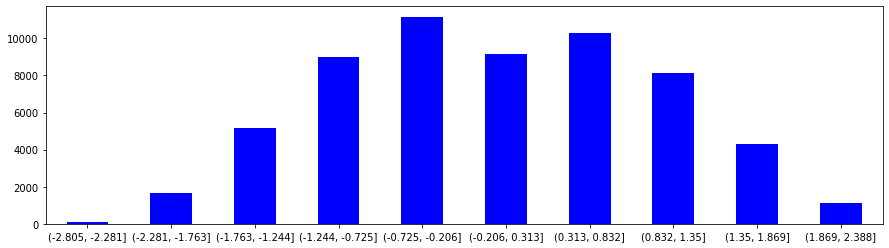

In [51]:
bins = pd.cut(dataset["density"],10)
ax = bins.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(15,4))
plt.show()

#### Writing BiasConfig
SageMaker Clarify also needs information on what the sensitive columns (`facets`) are, what the sensitive features (`facet_values_or_threshold`) may be, and what the desirable outcomes are (`label_values_or_threshold`).
SageMaker Clarify can handle both categorical and continuous data for `facet_values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data.

In [49]:
bias_config = clarify.BiasConfig(label_values_or_threshold=[1],
                                facet_name='density',
                                facet_values_or_threshold=[0.832])

In [50]:
clarify_processor.run_bias(data_config=bias_data_config,
                           bias_config=bias_config,
                           model_config=model_config,
                           model_predicted_label_config=predictions_config,
                           pre_training_methods='all',
                           post_training_methods='all')


Job Name:  Clarify-Bias-2021-05-09-02-36-59-131
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker-featurestore-insurance/training_input/dataset.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker_clarify/output/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ca-central-1-314997521033/sagemaker_clarify/output', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
................................

#### Cleanup. Delete SageMaker Endpoint.

In [106]:
sagemaker_client.delete_endpoint(EndpointName=predictor.endpoint_name)

{'ResponseMetadata': {'RequestId': '28703a4b-d21d-45db-acc1-0ad2aca87a8c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '28703a4b-d21d-45db-acc1-0ad2aca87a8c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Fri, 30 Apr 2021 02:05:23 GMT'},
  'RetryAttempts': 0}}